<a href="https://colab.research.google.com/github/11jolek11/BigDataHCVproject/blob/SMOTE/BigDataHCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q imbalanced-learn
# !pip install -q ipympl

# from google.colab import output
# output.enable_custom_widget_manager()

import matplotlib.pyplot as plt
# %matplotlib notebook
# /content/drive/MyDrive/Colab Notebooks/datasets/hcvdat0.csv

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
# TODO: KNN imputer może nie być najlepszym wyborem
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN

# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost

# Zastanów sie czy nie uzyc adaboost
from sklearn.ensemble import AdaBoostClassifier

In [3]:
# hcv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/hcvdat0.csv', header=0)
hcv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/hcvdat0.csv', header=0)
hcv[hcv.isna().any(axis=1)]
print()

In [4]:
np.unique(hcv["Category"])

array(['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis',
       '2=Fibrosis', '3=Cirrhosis'], dtype=object)

In [5]:
hcv.replace('1=Hepatitis', '1=HCV', inplace=True)
hcv.replace('2=Fibrosis', '1=HCV', inplace=True)
hcv.replace('3=Cirrhosis', '1=HCV', inplace=True)

In [6]:
hcv["Category"].value_counts()

0=Blood Donor             533
1=HCV                      75
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [7]:
# indexes_to_delete = hcv.index[hcv["Category"] == "0=Blood Donor"]
# drop_indices = np.random.choice(indexes_to_delete, 200, replace=False)
# hcv.drop(drop_indices, inplace=True)
hcv.drop(hcv[hcv["Category"] == '0s=suspect Blood Donor'].index, inplace=True)

In [8]:
hcv["Category"].value_counts()

0=Blood Donor    533
1=HCV             75
Name: Category, dtype: int64

In [9]:
# sns.countplot(x=hcv["Category"])

In [10]:
# sns.heatmap(hcv.corr(), annot=True, cmap='rainbow')

In [11]:
encoder = LabelEncoder()
hcv["Sex"] = encoder.fit_transform(hcv["Sex"])
hcv["Category"] = encoder.fit_transform(hcv["Category"])
classes = encoder.classes_
encoded_classes = encoder.transform(classes)
original_encoded_dict = dict(zip(classes, encoded_classes))
print(original_encoded_dict)

{'0=Blood Donor': 0, '1=HCV': 1}


In [12]:
print(encoder.get_params(deep=True))

{}


In [13]:
imputer = IterativeImputer(max_iter=10, random_state=0).set_output(transform="pandas")
hcv = imputer.fit_transform(hcv)
hcv[hcv.isna().any(axis=1)]

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT


In [14]:
hcv.shape

(608, 14)

In [15]:
hcv_target = hcv["Category"]
hcv.drop(columns=["Category"], inplace=True)

In [16]:
# pca_pipeline = Pipeline(
#     [
#       ('scaler', StandardScaler()),
#       ('pca_dim_reduction', PCA(n_components=3)),
#     ]
# )

# hcv_pca = pd.DataFrame(pca_pipeline.fit_transform(hcv), columns = ['pca1', 'pca2', 'pca3'])

#PCA n=2

In [17]:
pca_pipeline = Pipeline(
    [
      ('scaler', StandardScaler()),
      ('pca_dim_reduction', PCA(n_components=2)),
    ]
)

hcv_pca = pd.DataFrame(pca_pipeline.fit_transform(hcv), columns = ['pca1', 'pca2'])

In [18]:
std_scaler = StandardScaler()

smote = SMOTE()
adasyn = ADASYN()
smoteenn = SMOTEENN()

In [19]:
# x_train, x_test, y_train, y_test = train_test_split(hcv, hcv_target, stratify=hcv_target)
x_train, x_test, y_train, y_test = train_test_split(hcv_pca, hcv_target, stratify=hcv_target)

x_train = std_scaler.fit_transform(x_train)
x_test = std_scaler.transform(x_test)

X_train_smt, Y_train_smt = smote.fit_resample(x_train, y_train)
X_train_ada, Y_train_ada = adasyn.fit_resample(x_train, y_train)
X_train_enn, Y_train_enn = smoteenn.fit_resample(x_train, y_train)

In [20]:
print(X_train_smt.shape)
print(X_train_ada.shape)
print(X_train_enn.shape)
print()

print(Y_train_smt.shape)
print(Y_train_ada.shape)
print(Y_train_enn.shape)
print()


temp, count = np.unique(Y_train_smt, return_counts=True)
print(np.asarray((temp, count)).T)
print()

temp, count = np.unique(Y_train_ada, return_counts=True)
print(np.asarray((temp, count)).T)
print()

temp, count = np.unique(Y_train_enn, return_counts=True)
print(np.asarray((temp, count)).T)
print()

(800, 2)
(798, 2)
(606, 2)

(800,)
(798,)
(606,)

[[  0. 400.]
 [  1. 400.]]

[[  0. 400.]
 [  1. 398.]]

[[  0. 287.]
 [  1. 319.]]



<Axes: xlabel='pca1', ylabel='pca2'>

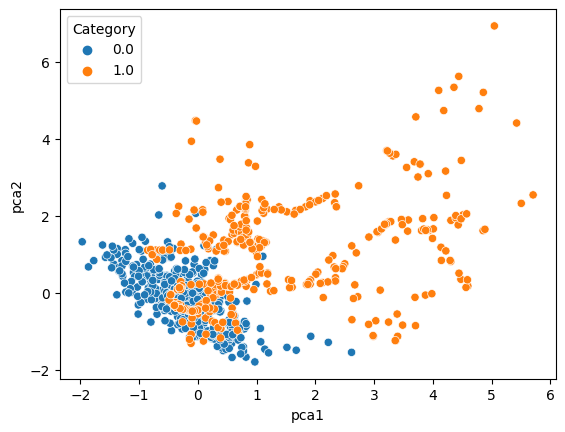

In [21]:
temp = pd.DataFrame(X_train_smt, columns=['pca1', 'pca2'])
sns.scatterplot(data=temp, x="pca1", y="pca2", hue=Y_train_smt)

<Axes: xlabel='pca1', ylabel='pca2'>

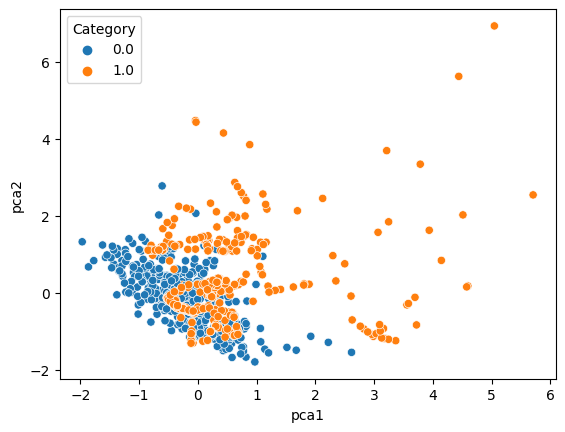

In [22]:
temp = pd.DataFrame(X_train_ada, columns=['pca1', 'pca2'])
sns.scatterplot(data=temp, x="pca1", y="pca2", hue=Y_train_ada)

<Axes: xlabel='pca1', ylabel='pca2'>

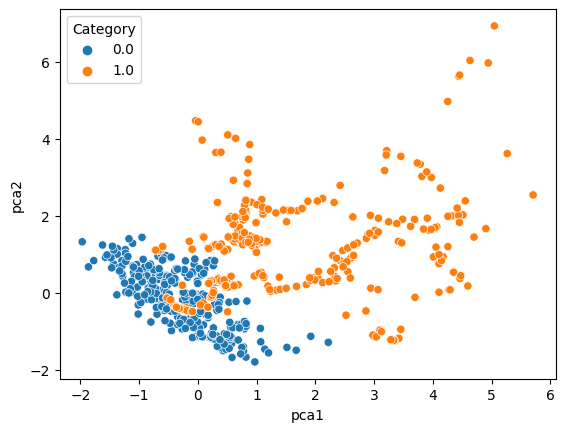

In [23]:
temp = pd.DataFrame(X_train_enn, columns=['pca1', 'pca2'])
sns.scatterplot(data=temp, x="pca1", y="pca2", hue=Y_train_enn)

In [24]:

# pca_pipeline = Pipeline(
#     [
#       ('scaler', StandardScaler()),
#       ('pca_dim_reduction', PCA(n_components=2)),
#     ]
# )

# hcv_pca = pd.DataFrame(pca_pipeline.fit_transform(hcv), columns = ['pca1', 'pca2'])
# sns.scatterplot(data=hcv_pca, x='pca1', y='pca2', hue=hcv_target)

# PCA n=3

In [25]:
# from mpl_toolkits.mplot3d import Axes3D


# pca_pipeline = Pipeline(
#     [
#       ('scaler', StandardScaler()),
#       ('pca_dim_reduction', PCA(n_components=3)),
#     ]
# )

# hcv_pca = pd.DataFrame(pca_pipeline.fit_transform(hcv), columns = ['pca1', 'pca2', 'pca3'])

In [26]:
# std_scaler = StandardScaler()

# smote = SMOTE()
# adasyn = ADASYN()
# smoteenn = SMOTEENN()

In [27]:
# x_train, x_test, y_train, y_test = train_test_split(hcv_pca, hcv_target, stratify=hcv_target)

# x_train = std_scaler.fit_transform(x_train)
# x_test = std_scaler.transform(x_test)

# X_train_smt, Y_train_smt = smote.fit_resample(x_train, y_train)
# X_train_ada, Y_train_ada = adasyn.fit_resample(x_train, y_train)
# X_train_enn, Y_train_enn = smoteenn.fit_resample(x_train, y_train)

In [28]:
# print(X_train_smt.shape)
# print(X_train_ada.shape)
# print(X_train_enn.shape)
# print()

# print(Y_train_smt.shape)
# print(Y_train_ada.shape)
# print(Y_train_enn.shape)
# print()


# temp, count = np.unique(Y_train_smt, return_counts=True)
# print(np.asarray((temp, count)).T)
# print()

# temp, count = np.unique(Y_train_ada, return_counts=True)
# print(np.asarray((temp, count)).T)
# print()

# temp, count = np.unique(Y_train_enn, return_counts=True)
# print(np.asarray((temp, count)).T)
# print()

In [29]:
# from mpl_toolkits.mplot3d import Axes3D
# !pip install -q ipympl
# # !pip install pyqt5

# from google.colab import output
# output.enable_custom_widget_manager()

# # %matplotlib widget
# # %matplotlib notebook

# sns.set(style = "darkgrid")

# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')

# temp = pd.DataFrame(X_train_enn, columns=['pca1', 'pca2', 'pca3'])

# x = temp['pca1']
# y = temp['pca2']
# z = temp['pca3']

# ax.set_xlabel("pca1")
# ax.set_ylabel("pca2")
# ax.set_zlabel("pca3")

# colors = {0.: "tab:green", 1.: "tab:orange"}

# ax.scatter(x, y, z, c=Y_train_enn.map(colors))
# plt.title("enn")
# plt.show()

In [30]:
# from mpl_toolkits.mplot3d import Axes3D
# !pip install -q ipympl
# # !pip install pyqt5

# from google.colab import output
# output.enable_custom_widget_manager()

# # %matplotlib widget
# # %matplotlib notebook

# sns.set(style = "darkgrid")

# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')

# temp = pd.DataFrame(X_train_smt, columns=['pca1', 'pca2', 'pca3'])

# x = temp['pca1']
# y = temp['pca2']
# z = temp['pca3']

# ax.set_xlabel("pca1")
# ax.set_ylabel("pca2")
# ax.set_zlabel("pca3")

# colors = {0.: "tab:green", 1.: "tab:orange"}

# ax.scatter(x, y, z, c=Y_train_smt.map(colors))
# plt.title("smt")
# plt.show()

In [31]:
# from mpl_toolkits.mplot3d import Axes3D
# !pip install -q ipympl
# # !pip install pyqt5

# from google.colab import output
# output.enable_custom_widget_manager()

# # %matplotlib widget
# # %matplotlib notebook

# sns.set(style = "darkgrid")

# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')

# temp = pd.DataFrame(X_train_ada, columns=['pca1', 'pca2', 'pca3'])

# x = temp['pca1']
# y = temp['pca2']
# z = temp['pca3']

# ax.set_xlabel("pca1")
# ax.set_ylabel("pca2")
# ax.set_zlabel("pca3")

# colors = {0.: "tab:green", 1.: "tab:orange"}

# ax.scatter(x, y, z, c=Y_train_ada.map(colors))
# plt.title("ada")
# plt.show()

# Models

In [40]:
rfc = RandomForestClassifier()
params = {"max_depth": (3, 4, 5, 6)}
grid = GridSearchCV(rfc, params)
grid.fit(X_train_enn, Y_train_enn)
Y_train_enn_predict = grid.best_estimator_.predict(x_test)
print(classification_report(y_test, Y_train_enn_predict))
print(classification_report_imbalanced(y_test, Y_train_enn_predict))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       133
         1.0       0.57      0.84      0.68        19

    accuracy                           0.90       152
   macro avg       0.77      0.88      0.81       152
weighted avg       0.93      0.90      0.91       152

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.91      0.84      0.94      0.88      0.77       133
        1.0       0.57      0.84      0.91      0.68      0.88      0.76        19

avg / total       0.93      0.90      0.85      0.91      0.88      0.77       152



In [34]:
knn = KNeighborsClassifier()
params = {"n_neighbors": tuple([i for i in range(1, 7)])}
grid = GridSearchCV(knn, params)
grid.fit(X_train_enn, Y_train_enn)
Y_train_enn_predict = grid.best_estimator_.predict(x_test)
print(classification_report(y_test, Y_train_enn_predict))
print(classification_report_imbalanced(y_test, Y_train_enn_predict))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       133
         1.0       0.54      0.79      0.64        19

    accuracy                           0.89       152
   macro avg       0.75      0.85      0.79       152
weighted avg       0.91      0.89      0.90       152

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.90      0.79      0.93      0.84      0.72       133
        1.0       0.54      0.79      0.90      0.64      0.84      0.70        19

avg / total       0.91      0.89      0.80      0.90      0.84      0.72       152



In [35]:
# params={'C':np.logspace(-10, 1, 15)}
svc = SVC()
params={'C': (1, 2, 3), "kernel": ('linear', 'poly', 'rbf', 'sigmoid')}
grid = GridSearchCV(svc, params)
grid.fit(X_train_enn, Y_train_enn)
Y_train_enn_predict = grid.best_estimator_.predict(x_test)
print(classification_report(y_test, Y_train_enn_predict))
print(classification_report_imbalanced(y_test, Y_train_enn_predict))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       133
         1.0       0.64      0.74      0.68        19

    accuracy                           0.91       152
   macro avg       0.80      0.84      0.82       152
weighted avg       0.92      0.91      0.92       152

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.94      0.74      0.95      0.83      0.71       133
        1.0       0.64      0.74      0.94      0.68      0.83      0.68        19

avg / total       0.92      0.91      0.76      0.92      0.83      0.70       152



In [36]:
dtc = DecisionTreeClassifier()
params={"max_depth": tuple([i for i in range(1, 10)])}
grid = GridSearchCV(dtc, params)
grid.fit(X_train_enn, Y_train_enn)
Y_train_enn_predict = grid.best_estimator_.predict(x_test)
print(classification_report(y_test, Y_train_enn_predict))
print(classification_report_imbalanced(y_test, Y_train_enn_predict))

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93       133
         1.0       0.50      0.79      0.61        19

    accuracy                           0.88       152
   macro avg       0.73      0.84      0.77       152
weighted avg       0.91      0.88      0.89       152

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.89      0.79      0.93      0.84      0.71       133
        1.0       0.50      0.79      0.89      0.61      0.84      0.69        19

avg / total       0.91      0.88      0.80      0.89      0.84      0.71       152



In [37]:
gnb = GaussianNB()
gnb.fit(X_train_enn, Y_train_enn)
Y_train_enn_predict = gnb.predict(x_test)
print(classification_report(y_test, Y_train_enn_predict))
print(classification_report_imbalanced(y_test, Y_train_enn_predict))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       133
         1.0       0.62      0.68      0.65        19

    accuracy                           0.91       152
   macro avg       0.79      0.81      0.80       152
weighted avg       0.91      0.91      0.91       152

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.94      0.68      0.95      0.80      0.66       133
        1.0       0.62      0.68      0.94      0.65      0.80      0.63        19

avg / total       0.91      0.91      0.72      0.91      0.80      0.66       152



In [38]:
xgb_c = xgboost.XGBClassifier()
xgb_c.fit(X_train_enn, Y_train_enn)
Y_train_enn_predict = xgb_c.predict(x_test)
print(classification_report(y_test, Y_train_enn_predict))
print(classification_report_imbalanced(y_test, Y_train_enn_predict))

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92       133
         1.0       0.48      0.84      0.62        19

    accuracy                           0.87       152
   macro avg       0.73      0.86      0.77       152
weighted avg       0.91      0.87      0.88       152

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.87      0.84      0.92      0.86      0.74       133
        1.0       0.48      0.84      0.87      0.62      0.86      0.73        19

avg / total       0.91      0.87      0.85      0.88      0.86      0.74       152



In [39]:
adab_c = AdaBoostClassifier()
params={"n_estimators": tuple([i for i in range(50, 300, 50)])}
grid = GridSearchCV(adab_c, params)
grid.fit(X_train_enn, Y_train_enn)
Y_train_enn_predict = grid.best_estimator_.predict(x_test)
print(classification_report(y_test, Y_train_enn_predict))
print(classification_report_imbalanced(y_test, Y_train_enn_predict))

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91       133
         1.0       0.44      0.74      0.55        19

    accuracy                           0.85       152
   macro avg       0.70      0.80      0.73       152
weighted avg       0.89      0.85      0.86       152

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.86      0.74      0.91      0.80      0.65       133
        1.0       0.44      0.74      0.86      0.55      0.80      0.63        19

avg / total       0.89      0.85      0.75      0.86      0.80      0.64       152

